In [1]:
import ROOT 
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootConfReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTask.h"')
ROOT.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

Welcome to JupyROOT 6.20/08


0

In [2]:
def Mjets(*arg):
    # arg: list of jets
    # return: invariant mass of jets
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

# Basic information

In [3]:
# Open root file
# root_file = './ppjj/Events/run_02/tag_1_delphes_events.root'
root_file = '../../Software/pythia8307/HVmodel/test.root'
f = ROOT.TFile(root_file)
# Print the tree structure
f.ls()

tree = f.Get("Delphes")

TFile**		../../Software/pythia8307/HVmodel/test.root	
 TFile*		../../Software/pythia8307/HVmodel/test.root	
  KEY: TProcessID	ProcessID0;1	d5489b38-8ff2-11ee-8a5d-0401a8c0beef
  KEY: TTree	Delphes;1	Analysis tree


In [4]:
# Get the branch names
for branch in tree.GetListOfBranches():
    print(branch.GetName())

Event
Event_size
Weight
Weight_size
Particle
Particle_size
Track
Track_size
Tower
Tower_size
EFlowTrack
EFlowTrack_size
EFlowPhoton
EFlowPhoton_size
EFlowNeutralHadron
EFlowNeutralHadron_size
GenJet
GenJet_size
GenMissingET
GenMissingET_size
Jet
Jet_size
Electron
Electron_size
Photon
Photon_size
Muon
Muon_size
FatJet
FatJet_size
MissingET
MissingET_size
ScalarHT
ScalarHT_size


In [5]:
# print Pythia data
for event_id, event in tqdm(enumerate(tree)):      

    if event_id == 163:
        print(event_id)
        print(f'{"pid":^5} {"PID":^8} {"M1":^8} {"M2":^8} {"D1":^8} {"D2":^8} {"Px":^8} {"Py":^8} {"Pz":^8}')
        printed = False
        for p_id, particle in enumerate(event.Particle):
            print(f'{p_id:5} {particle.PID:8} {particle.M1:8} {particle.M2:8} {particle.D1:8} {particle.D2:8} {particle.Px:8.2} {particle.Py:8.2} {particle.Pz:8.2} {particle.PT:8.2}')

        break


163it [00:00, 486.49it/s]

163
 pid    PID       M1       M2       D1       D2       Px       Py       Pz   
    0       -2        4       -1        3        3      0.0      0.0    2e+03      0.0
    1       21        4       -1       11       11   -1e+02  3.3e+01 -5.8e+01  1.1e+02
    2        2        6       -1        3        3      0.0      0.0 -3.8e+03      0.0
    3  4900023        0        2        7        7      0.0      0.0 -1.8e+03      0.0
    4       -2        8       -1        0        1  1.4e-14 -3.6e-15  2.1e+03  1.5e-14
    5        2        8       -1       23       23  1.5e+01  2.2e+01  7.7e+01  2.7e+01
    6        2        9       -1        2        2  7.1e-15      0.0 -3.8e+03  7.1e-15
    7  4900023        3       -1       10       10    1e+02 -3.3e+01 -1.7e+03  1.1e+02
    8       21       19       -1        4        5      0.0 -1.8e-15  2.2e+03  1.8e-15
    9        2       14       -1        6        6  1.8e-15      0.0 -3.8e+03  1.8e-15
   10  4900023        7       -1       21       

# Selection

In [6]:
def HV_selection(tree):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0

    n_event_count = 0
    n_jet_count = 0
    jet_pt_count = 0
    jet_eta_count = 0
    mjj = []

    pt = [[],[]]

    for event_id, event in tqdm(enumerate(tree)):
        n_event_count += 1

        if event.Jet_size < 2:
            continue
        n_jet_count += 1

        pt[0].append(event.Jet[0].PT)
        pt[1].append(event.Jet[1].PT)
        if event.Jet[1].PT < 750:
            continue
        jet_pt_count += 1

        if abs(event.Jet[0].Eta) > 2.0 or abs(event.Jet[1].Eta) > 2.0:
            continue
        jet_eta_count += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj.append(Mjets(*jets))

    mjj = np.array(mjj)
    SR_count = ((mjj > 4700) & (mjj < 5500)).sum()
    SB_count = (((mjj > 4300) & (mjj < 4700)) | ((mjj > 5500) & (mjj < 5900))).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n jet cut': n_jet_count,
        'jet pt cut': jet_pt_count,
        'jet eta cut': jet_eta_count,
        'Signal region': SR_count,
        'Sideband region': SB_count,
    }

    results = {
        'mjj': mjj,
        'pt': np.array(pt),
        'cutflow_number': cutflow_number,
    }

    return results

In [7]:
root_file = '../../Software/pythia8307/HVmodel/test_100k.root'
f = ROOT.TFile(root_file)
tree_s = f.Get("Delphes")

results_s = HV_selection(tree_s)

10000it [00:16, 600.49it/s]


In [8]:
root_file = './ppjj/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree_b = f.Get("Delphes")

results_b = HV_selection(tree_b)

100000it [02:22, 699.87it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file ./ppjj/Events/run_02/tag_1_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file ./ppjj/Events/run_02/tag_1_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float T; //number
vs
   float CtgTheta; //number
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float X; //number
vs
   float D0; //number
Warning in <TStreamerInfo::Compare

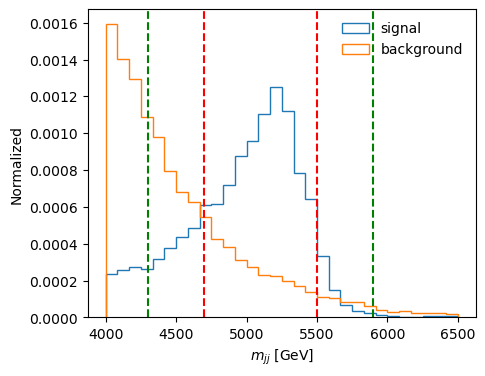

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(results_s['mjj'], range=(4000, 6500), density=True, bins=30, histtype='step', label='signal')
ax.hist(results_b['mjj'], range=(4000, 6500), density=True, bins=30, histtype='step', label='background')

# 指定要繪製垂直線的x座標
SRSB_region = [[4700, 5500], [4300, 5900]]
x_SR = SRSB_region[0]
x_SB = SRSB_region[1]
# 使用axvline函數繪製垂直線
ax.axvline(x=x_SR[0], color='r', linestyle='--')
ax.axvline(x=x_SR[1], color='r', linestyle='--')

ax.axvline(x=x_SB[0], color='g', linestyle='--')
ax.axvline(x=x_SB[1], color='g', linestyle='--')

ax.set_xlabel('$m_{jj}$ [GeV]')
ax.set_ylabel('Normalized')
ax.legend(frameon=False)

plt.savefig('../figures/HVmodel_mjj_distribution.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

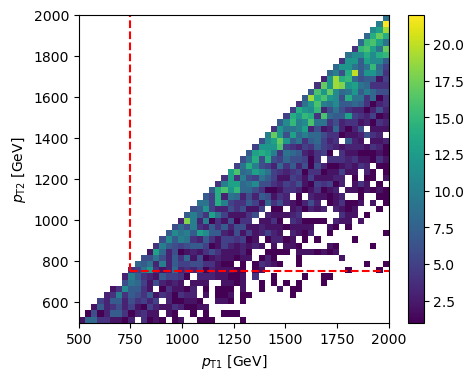

In [18]:
# plot leading and sub-leading pT distribution in 2d histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
pt = results_s['pt']
hs = ax.hist2d(pt[0], pt[1], range=((500, 2000), (500, 2000)), bins=50, cmin=1)
# show color bar
fig.colorbar(hs[3], ax=ax)

ax.plot([750,750], [750,2000], color='r', linestyle='--')
ax.plot([750,2000], [750,750], color='r', linestyle='--')

ax.set_xlabel('$p_{\mathrm{T1}}$ [GeV]')
ax.set_ylabel('$p_{\mathrm{T2}}$ [GeV]')
plt.savefig('../figures/HVmodel_pt_distribution-sig.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

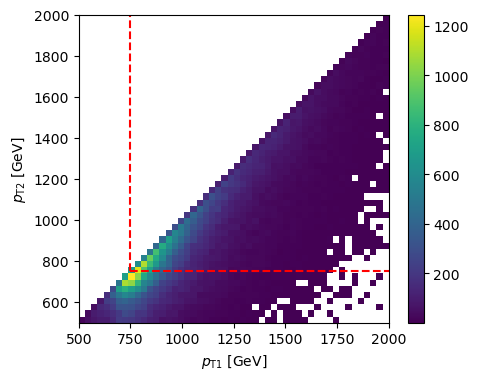

In [19]:
# plot leading and sub-leading pT distribution in 2d histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
pt = results_b['pt']
hs = ax.hist2d(pt[0], pt[1], range=((500, 2000), (500, 2000)), bins=50, cmin=1)
# show color bar
fig.colorbar(hs[3], ax=ax)

ax.plot([750,750], [750,2000], color='r', linestyle='--')
ax.plot([750,2000], [750,750], color='r', linestyle='--')

ax.set_xlabel('$p_{\mathrm{T1}}$ [GeV]')
ax.set_ylabel('$p_{\mathrm{T2}}$ [GeV]')
plt.savefig('../figures/HVmodel_pt_distribution-bkg.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()